<a href="https://colab.research.google.com/github/andreytsimbalov/News_Classification_and_Vectorization/blob/main/Parser_news_RIA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Парсер с Риа новости

Данная программа парсит новости с https://ria.ru/search/ за определенный период

In [1]:
import requests
import threading
from bs4 import BeautifulSoup
import numpy as np
from tqdm.notebook import tqdm
import pandas as pd
import time
import random

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
def take_ria_news(url_one):
    r=requests.get(url_one).text
    bs = BeautifulSoup(r, 'html.parser')

    tags = [tag.text for tag in bs.find_all('a', class_ = 'article__tags-item')] 

    texts = bs.find_all('div', class_ = 'article__block')
    main_text = ''
    for _ in texts:
        t = _.find('div',class_ ="article__quote")
        if not t is None:
            main_text += t.text+' '

        t = _.find('div',class_ ="article__text")
        if not t is None:
            main_text += t.text+' '

    return tags, main_text

In [3]:
def take_news(link): # просматривает новость на ria search

    new_item = {}
    new_item['date'] = link.find('div', class_="list-item__date").text.split(', ')[0]
    new_item['time'] = link.find('div', class_="list-item__date").text.split(', ')[1]
    new_item['views'] = int(link.find('div', class_='list-item__views-text').text)
    
    new_item['headline'] = link.find('span',class_="share").get('data-title')
    new_item['link']= link.find('a').get('href')
    new_item['tags'] = []
    new_item['text'] = ''

    flag = new_item['link'].find('ria.ru')!=-1
    if (flag):
        try_to_get_tags_and_text = True
        try_counter = 0

        while try_to_get_tags_and_text: 
          try_counter+=1
          if try_counter>20:
            print("dont getted tags and text "+ str(new_item['link']))
            try_to_get_tags_and_text = False
            continue

          try:
            new_item['tags'], new_item['text'] = take_ria_news(new_item['link']) #, new_item['text']
          except:
            print("smth is wrong with t&t")

          if new_item['text']=='':
            time.sleep(random.uniform(0.01,0.1)+ try_counter//10)
            time.sleep(0)
          else:
            try_to_get_tags_and_text = False
              
    else:
      print("we have not news_text on link "+str(link))
    return new_item

In [4]:
lock = threading.Lock()

def take_1_news(news_item):
  views_on_news = int(news_item.find('div', class_='list-item__views-text').text)
  flag = news_item.find('a').get('href').find('radiosputnik.ria.ru')==-1 and \
      views_on_news>MIN_VIEWS_ON_NEWS 

  if flag: 
      news_one = take_news(news_item)
      global news
      with lock:
        news.extend([news_one])


def take_20_news(i, par):
  one_news_of_time = time.time()

  offset = i*20
  params = par.copy()
  params['offset'] = offset


  success_try_to_parsing = True
  try_counter=0

  while success_try_to_parsing:
    try_counter+=1
    r = requests.get(url,params = params)
    soup = BeautifulSoup(r.text, 'html.parser')

    thrs = [threading.Thread(target=take_1_news, args= (news_item,)) 
            for news_item in soup.find_all('div', class_ =  'list-item')]
    
    if len(thrs)<20:
      if try_counter>30:
        print(f'ERROR__ {i} {params}')
        return
      time.sleep(random.uniform(0.01, 0.1)+try_counter//20)
      continue
    else:
      success_try_to_parsing = False

    for th in thrs:
      th.start()
    for th in thrs:
      th.join()

    time_delay = time.time()-one_news_of_time
    global max_time_delay
    with lock:
      max_time_delay = max(max_time_delay, time_delay)
  
  print(f'{i} finished {len(news)} ({i*20/len_news})')
  

# Сбор данных

In [14]:
url = 'https://ria.ru/search/'

HEADERS = {'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) '
                         'AppleWebKit/537.36 (KHTML, like Gecko) Chrome/84.0.4147.125 Safari/537.36', 
          'accept': '*/*'}

PARAMS = {'interval': "period",
          'date_from':'2020-01-01',
          'date_to':'2020-01-01',
          'offset': 0}

MIN_VIEWS_ON_NEWS = 10000 #отсев новостей с менее 10 000 просмотров

In [15]:
r = requests.get(url,params = PARAMS)
soup = BeautifulSoup(r.text, 'html.parser')

len_news = int(soup.find_all('div', class_ =  'rubric-count m-active')[0].text.split(' ')[0])
len_news

373

In [16]:
news = []
max_time_delay=0
max_thread_number = 10
threads_index = set([])


arr_news_of_time = time.time()

thrs_main = [threading.Thread(target=take_20_news, args= (i,PARAMS,)) 
              for i in range(len_news//20)]

now_threads = set([])

iterator = 0

while iterator<len(thrs_main):
  finished_threads=set([])
  for th in now_threads:
    if not th.isAlive():
      finished_threads.add(th)
  now_threads-=finished_threads
  
  while len(now_threads)<max_thread_number:
    now_threads.add(thrs_main[iterator])
    thrs_main[iterator].start()
    iterator+=1
    time.sleep(0.1)
  
  time.sleep(0)


for ths in thrs_main:
  ths.join()

print(time.time()-arr_news_of_time)
print(f'max_time_delay {max_time_delay}')
len(news)

0 finished 24 (0.0)
4 finished 27 (0.21447721179624665)
8 finished 31 (0.4289544235924933)
2 finished 33 (0.10723860589812333)
1 finished 34 (0.05361930294906166)
7 finished 35 (0.3753351206434316)
5 finished 37 (0.2680965147453083)
3 finished 39 (0.16085790884718498)
6 finished 41 (0.32171581769436997)
15 finished 56 (0.8042895442359249)
14 finished 64 (0.7506702412868632)
12 finished 66 (0.6434316353887399)
17 finished 74 (0.9115281501340483)
13 finished 75 (0.6970509383378016)
ERROR__ 9 {'interval': 'period', 'date_from': '2020-01-01', 'date_to': '2020-01-01', 'offset': 180}
ERROR__ 11 {'interval': 'period', 'date_from': '2020-01-01', 'date_to': '2020-01-01', 'offset': 220}
ERROR__ 10 {'interval': 'period', 'date_from': '2020-01-01', 'date_to': '2020-01-01', 'offset': 200}
ERROR__ 16 {'interval': 'period', 'date_from': '2020-01-01', 'date_to': '2020-01-01', 'offset': 320}
51.69085478782654
max_time_delay 16.23751187324524


75

In [18]:
news[0]

{'date': '1 января 2020',
 'headline': 'Полицейские на Урале застрелили напавшего на них мужчину',
 'link': 'https://ria.ru/20200101/1563066011.html',
 'tags': ['Валерий Горелых',
  'Следственный комитет России (СК РФ)',
  'Министерство внутренних дел РФ (МВД России)',
  'Свердловская область',
  'Екатеринбург',
  'Камышлов',
  'Происшествия'],
 'text': 'ЕКАТЕРИНБУРГ, 1 янв — РИА Новости. Полицейские в небольшом городе Камышлов на юге Свердловской области застрелили пьяного молодого человека, набросившегося на них с монтировкой, сообщил в среду журналистам руководитель пресс-службы областного управления МВД Валерий Горелых. Ранее в Telegram-каналах появилась информация о том, что в Камышлове произошел новогодний семейный скандал. На место вызвали полицию, но глава семейства накинулся на полицейских с монтировкой, правоохранители его застрелили. Горелых эту информацию подтвердил. По его словам, инцидент произошел во вторник в 21:40 (19:40 мск). В дежурную часть поступил звонок от житель

# Графики просмотров - views

In [21]:
views = np.array([])
for n in news:
    views = np.append(views,n['views'])
views = views.astype(int)
views.sort()
views[:10]

array([10054, 10163, 10406, 10574, 11189, 11613, 12064, 12386, 13016,
       14630])

In [22]:
len(views[views>1100000])

1

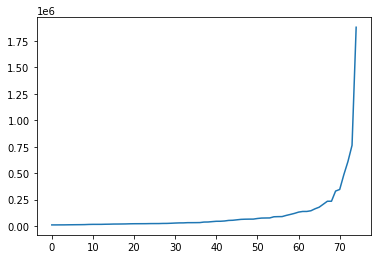

In [23]:
plt.plot(views)
plt.show()

In [24]:
num_views_hist = 100
views_hist = np.histogram(views, bins = np.linspace(views.min(),views.max(), num_views_hist))
views_hist = views_hist[0].astype(np.int64)
views_hist

array([31, 12,  7,  4,  4,  2,  3,  1,  2,  0,  1,  2,  0,  0,  0,  0,  1,
        1,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  1,  0,  0,
        0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1])

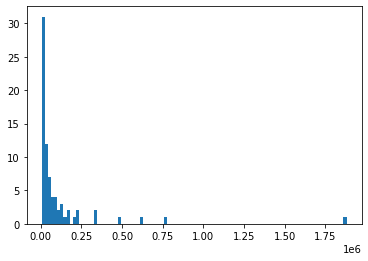

In [25]:
plt.hist(views, bins = num_views_hist)#np.linspace(0,len(views), 7)
plt.show()

# Создание датасета

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

md = '/content/drive/My Drive/Colab Notebooks/Diplom/'

Mounted at /content/drive


In [26]:
data = pd.DataFrame(news)
data.head()

,date,time,views,headline,link,tags,text
0,1 января 2020,18:25,162457,Полицейские на Урале застрелили напавшего на н...,https://ria.ru/20200101/1563066011.html,"[Валерий Горелых, Следственный комитет России ...","ЕКАТЕРИНБУРГ, 1 янв — РИА Новости. Полицейские..."
1,1 января 2020,17:15,234118,Россиянин выиграл в лотерею миллиард рублей,https://ria.ru/20200101/1563065171.html,"[Москва, Общество]","МОСКВА, 1 янв — РИА Новости. Житель Москвы выи..."
2,1 января 2020,21:12,15338,Путин присвоил главе ФССП звание генерал-полко...,https://ria.ru/20200101/1563067715.html,"[Дмитрий Аристов, Федеральная служба судебных ...","МОСКВА, 1 янв — РИА Новости. Президент России ..."
3,1 января 2020,20:32,345334,Москвич выиграл в лотерею один миллиард рублей,https://ria.ru/20200101/1563067036.html,[Москва],"МОСКВА, 1 янв — РИА Новости. В новогоднем тира..."
4,1 января 2020,15:27,47194,Появилось видео чемпионского боя российского б...,https://rsport.ria.ru/20200101/1563063849.html,"[Смешанные боевые искусства (ММА), США, Спорт]","МОСКВА, 1 янв — РИА Новости. Официальный аккау..."


In [ ]:
data.index = np.arange(len(data))

In [ ]:
data.to_pickle(md+"data/news_08_2020")